In [48]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
data_path = r'RSonly_data.csv'

df = pd.read_csv(data_path)

In [25]:
df.head()

,Unnamed: 0,Date,Precipitation,Precipitation_(-1d),Precipitation_(-7d),Volumetric Soil moisture,2m_Temp,Discharge,Evaporation,Sat_Area,Real time storage
0,0,1/14/1990,0.0,0.000,0.000,0.005457,8.307883,622.0,232.819472,83.057795,1692000
1,1,4/4/1990,0.0,0.000,0.000,0.056118,14.296631,385.0,280.031540,81.264840,1639600
2,2,4/11/1990,0.0,0.000,0.000,0.022323,17.140956,36.0,661.206166,80.886614,1626800
3,3,4/20/1990,0.0,0.000,0.000,0.113441,13.940720,0.0,536.174092,80.579682,1613600
4,4,5/6/1990,0.0,0.319,1.164,0.114180,14.372926,523.0,563.486792,80.213382,1586200


In [26]:
#max_value = df['swv'].max()
#max_value



In [27]:
# @title GW

#from matplotlib import pyplot as plt
#df['GW'].plot(kind='hist', bins=20, title='GW')
#plt.gca().spines[['top', 'right',]].set_visible(False)

In [28]:
df.index = pd.to_datetime(df.Date)

In [29]:
df.head()

,Unnamed: 0,Date,Precipitation,Precipitation_(-1d),Precipitation_(-7d),Volumetric Soil moisture,2m_Temp,Discharge,Evaporation,Sat_Area,Real time storage
Date,,,,,,,,,,,
1990-01-14,0,1/14/1990,0.0,0.000,0.000,0.005457,8.307883,622.0,232.819472,83.057795,1692000
1990-04-04,1,4/4/1990,0.0,0.000,0.000,0.056118,14.296631,385.0,280.031540,81.264840,1639600
1990-04-11,2,4/11/1990,0.0,0.000,0.000,0.022323,17.140956,36.0,661.206166,80.886614,1626800
1990-04-20,3,4/20/1990,0.0,0.000,0.000,0.113441,13.940720,0.0,536.174092,80.579682,1613600
1990-05-06,4,5/6/1990,0.0,0.319,1.164,0.114180,14.372926,523.0,563.486792,80.213382,1586200


In [30]:
required_cols = ['Real time storage','Precipitation', 'Precipitation_(-1d)', 'Precipitation_(-7d)', 'Volumetric Soil moisture', '2m_Temp', 'Sat_Area']
#required_cols = ['Real time storage','Sat_Area']
df = df[required_cols]
df.head()

,Real time storage,Precipitation,Precipitation_(-1d),Precipitation_(-7d),Volumetric Soil moisture,2m_Temp,Sat_Area
Date,,,,,,,
1990-01-14,1692000,0.0,0.000,0.000,0.005457,8.307883,83.057795
1990-04-04,1639600,0.0,0.000,0.000,0.056118,14.296631,81.264840
1990-04-11,1626800,0.0,0.000,0.000,0.022323,17.140956,80.886614
1990-04-20,1613600,0.0,0.000,0.000,0.113441,13.940720,80.579682
1990-05-06,1586200,0.0,0.319,1.164,0.114180,14.372926,80.213382


In [31]:
df.isna().sum()

,0
Real time storage,0
Precipitation,0
Precipitation_(-1d),0
Precipitation_(-7d),0
Volumetric Soil moisture,0
2m_Temp,0
Sat_Area,0


In [32]:
from sklearn.preprocessing import MinMaxScaler

#Normalize data

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [33]:
sequence_length = 16
num_features = len(df.columns)

In [34]:
# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length]
    label = scaled_data[i+sequence_length][0]  # '_tempm' column index
    sequences.append(seq)
    labels.append(label)

 # Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (452, 16, 7)
Train Y shape: (452,)
Test X shape: (114, 16, 7)
Test Y shape: (114,)


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 16, 128)             │          69,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 16, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,489 (513.63 KB)

 Trainable params: 131,489 (513.63 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/ML_GW_GIS/best_model_weights.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3296 - val_loss: 0.1208
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0925 - val_loss: 0.0219
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0461 - val_loss: 0.0093
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0265 - val_loss: 0.0093
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0220 - val_loss: 0.0177
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0180 - val_loss: 0.0140
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0206 - val_loss: 0.0097
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.0158 - val_loss: 0.0055
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.0161 - val_loss: 0.0047
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0115 - val_loss: 0.0044
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0104 - val_loss: 0.0043
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0116 

In [38]:
import tensorflow as tf
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('/content/drive/MyDrive/ML_GW_GIS/best_model_weights.keras')
test_loss = best_model.evaluate(test_x, test_y)
print("Test Loss:", test_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 
Test Loss: 0.002525993390008807


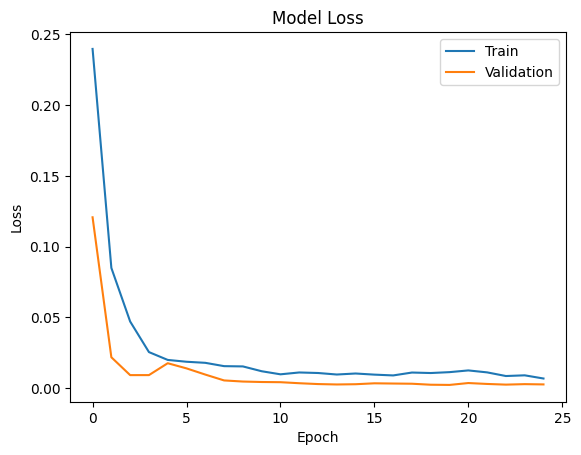

In [39]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you have trained the model and have the 'best_model' object
# Also, 'test_x' and 'test_y' should be available

# Predict temperatures using the trained model
predictions = best_model.predict(test_x)

# Calculate evaluation metrics
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Mean Absolute Error (MAE): 0.038629811000947215
Mean Squared Error (MSE): 0.002525993201207347
Root Mean Squared Error (RMSE): 0.05025925985534752


In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# y_true values
test_y_copies = np.repeat(test_y.reshape(-1, 1), test_x.shape[-1], axis=-1)
true_tem = scaler.inverse_transform(test_y_copies)
true_temp = true_tem[:,0]

# predicted values
prediction = best_model.predict(test_x)
# Repeat predictions to match the number of features the scaler expects
prediction_copies = np.repeat(prediction, test_x.shape[-1], axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,0]

# predicted values
#prediction = best_model.predict(test_x)
#prediction_copies = np.repeat(prediction, 6, axis=-1)
#predicted_temp = scaler.inverse_transform(prediction_copies)[:,0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [46]:
print(true_temp)

[ 72626.  76319.  98158. 105007. 202454. 448860. 493405. 530084. 570327.
 558684. 471435. 454036. 446041. 426389. 430441. 435000. 442138. 455398.
 500336. 546321. 586714. 598940. 602792. 556292. 427446. 368497. 306749.
 168447. 145273. 129583. 101582.  82849.  82589.  83327.  84070.  85259.
  87491. 115577. 121563. 160068. 165968. 174599. 181243. 210447. 223005.
 199339. 113063. 104528. 108249. 109596. 110691. 111689. 115146. 117474.
 120225. 121339. 132063. 138227. 151295. 159465. 165557. 166448. 173471.
 180378. 187142. 193668. 200715. 201483. 207144. 212826. 213623. 219579.
 225472. 226050. 231130. 245059. 253415. 264856. 228040. 197512. 151944.
 136271. 110064.  93945.  76358.  76031.  97042.  97765. 100989. 104881.
 122460. 123759. 131706. 132837. 138104. 138842. 145273. 153313. 162900.
 177225. 194869. 209185. 210684. 219335. 237902. 262309. 263126. 268796.
 269624. 327903. 336412. 350349. 422931. 466491.]


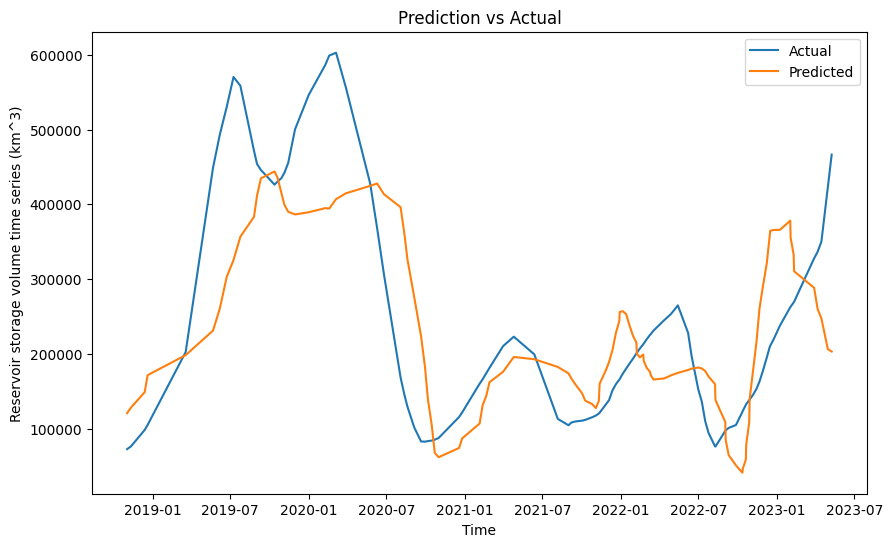

In [47]:
# Plotting predicted and actual groundwater
plt.figure(figsize=(10, 6))
plt.plot(df.index[-114:], true_temp[-114:], label='Actual')
plt.plot(df.index[-114:], predicted_temp[-114:], label='Predicted')
plt.title('Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Reservoir storage volume time series (km^3)')
plt.legend()
plt.ylim()
plt.show()